<a href="https://colab.research.google.com/github/Milad-Tz/Muffin-vs-Chihuahua---Binary-Image-Classification/blob/main/Muffin_vs_chihuahua_Binary_Image_Classification_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Muffin vs Chihuahua - Binary Image Classification

---



This project aims to build a binary image classifier to distinguish between images of muffins (1) and chihuahuas (0).

## Table of Contents

1. [Introduction](#introduction)
2. [Data Preparation and Preprocessing](#data-preparation-and-preprocessing)
3. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
4. [Feature Extraction using VGG16](#feature-extraction-using-vgg16)
5. [Model Selection using K-Fold Cross Validation](#model-selection-using-k-fold-cross-validation)
6. [Hyperparameter Tuning for Best Model Structure](#hyperparameter-tuning-for-best-model-structure)
7. [Model Evaluation](#model-evaluation)
8. [Conclusion](#conclusion)


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)

## 1.Introduction

Image classification is a fundamental task in computer vision, with applications ranging from autonomous driving to medical diagnosis. In this project, we address the challenge of distinguishing between two classes: muffins and Chihuahua dogs. Our goal is to develop a robust image classification model capable of accurately identifying these objects.

The project follows a systematic approach, starting with data preparation and preprocessing. We leverage the power of Google Colab and Google Drive to access and organize our dataset efficiently. Essential libraries are imported, and data generators are set up to preprocess images for feature extraction.

Next, we delve into exploratory data analysis (EDA) to gain insights into the distribution of classes and visualize sample images. This step lays the groundwork for understanding the dataset and informs subsequent modeling decisions.

Feature extraction plays a pivotal role in our approach, where we employ the VGG16 convolutional neural network pre-trained on ImageNet. By extracting high-level features from images, we aim to capture discriminative information essential for accurate classification.

Model selection is conducted using K-Fold Cross Validation, evaluating three different neural network architectures. We rigorously assess each model's performance to identify the most suitable architecture for our task.

Once the optimal model architecture is chosen, we fine-tune hyperparameters, focusing on the learning rate for further optimization. Through systematic experimentation and evaluation, we aim to enhance the model's effectiveness in classifying muffins and Chihuahuas.

Finally, we evaluate the selected model's performance on the test dataset, providing insights into its accuracy and ability to generalize to unseen data. We analyze key metrics such as accuracy and confusion matrices to assess the model's strengths and limitations.

Overall, this project showcases the effectiveness of deep learning techniques in image classification tasks, with implications for diverse domains such as animal recognition and food identification. By following a structured approach encompassing data preparation, feature extraction, model selection, and evaluation, we demonstrate the potential of deep learning models to tackle complex classification challenges.


# 2.Data Preparation and Preprocessing

The code in this section sets up the necessary environment for data preparation and preprocessing. It begins by importing essential libraries for Google Colab and mounting Google Drive to access the dataset. Then, it defines paths to the dataset stored in Google Drive. Parameters such as batch size and image size are specified for data preprocessing.

Data generators using `ImageDataGenerator` are created to preprocess the images for feature extraction. These generators are configured to rescale pixel values to a range of [0, 1]. Two generators are defined: `train_generator` for the training set and `validation_generator` for the validation set. Both generators are configured to load images from directories, resize them to a specified size, and process them in batches. The `shuffle` parameter is set to `False` to maintain consistency in the order of images during feature extraction.

This section lays the foundation for subsequent sections in the notebook, ensuring that the dataset is properly prepared and preprocessed for training machine learning models.


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths to the dataset in Google Drive
base_dir = '/content/drive/My Drive/datasets/muffin-vs-chihuahua-image-classification'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Define parameters
batch_size = 64
images_size = (150, 150)

# Data generators for feature extraction
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(train_dir,
                                              target_size=images_size,
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=False)

validation_generator = datagen.flow_from_directory(test_dir,
                                                   target_size=images_size,
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   shuffle=False)

Mounted at /content/drive
Found 4738 images belonging to 2 classes.
Found 1194 images belonging to 2 classes.


## 3. Exploratory Data Analysis (EDA)
In this section, we'll perform exploratory data analysis (EDA) on our dataset. We'll examine the distribution of classes in the training and testing sets, and visualize some random images from each class to gain insights into the data.

In [ ]:
# Get the class indices and number of images in each class for train and test
train_class_counts = {k: len(os.listdir(os.path.join(train_dir, k))) for k in os.listdir(train_dir)}
test_class_counts = {k: len(os.listdir(os.path.join(test_dir, k))) for k in os.listdir(test_dir)}

print("Training set class distribution:")
print(train_class_counts)

print("\nTesting set class distribution:")
print(test_class_counts)


Training set class distribution:
{'chihuahua': 2559, 'muffin': 2179}

Testing set class distribution:
{'muffin': 544, 'chihuahua': 650}


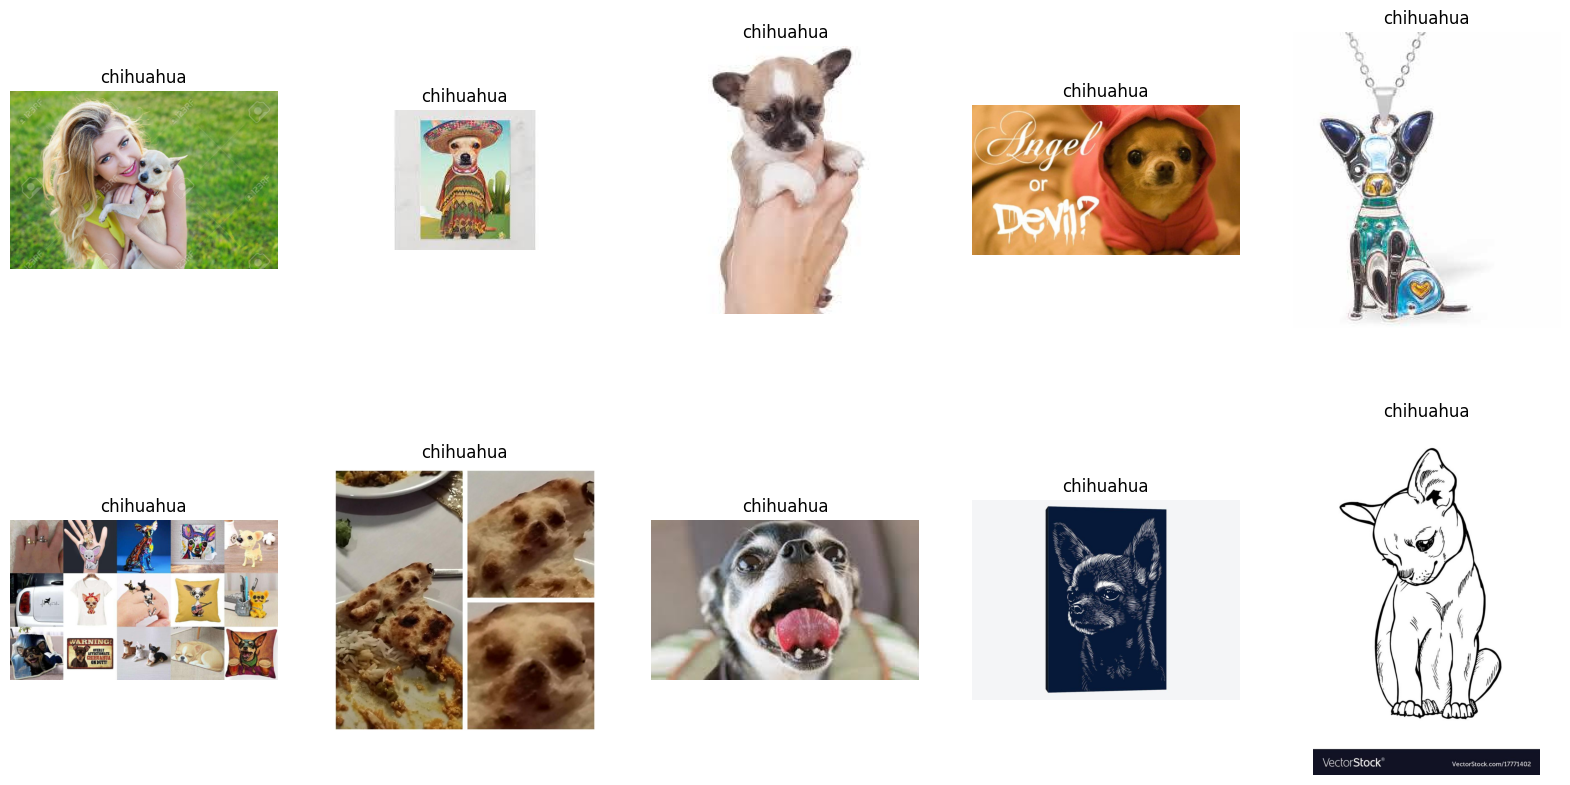

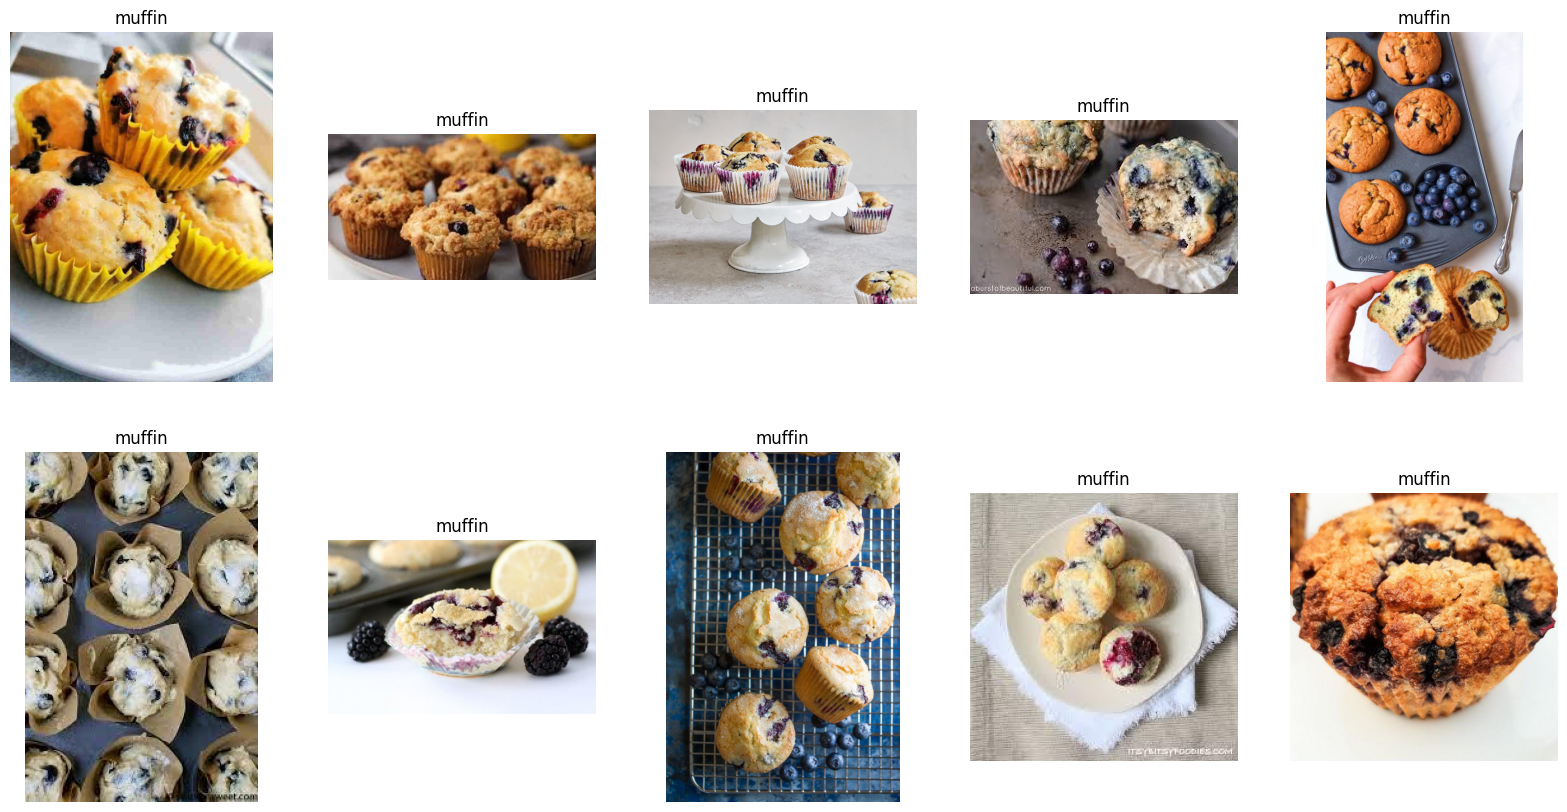

In [ ]:
import random
import matplotlib.pyplot as plt

# Function to plot random images from a directory
def plot_random_images(directory, class_name, num_images=10):
    # Get list of images
    images = os.listdir(os.path.join(directory, class_name))
    random_images = random.sample(images, num_images)

    plt.figure(figsize=(20, 10))
    for i, img_name in enumerate(random_images):
        img_path = os.path.join(directory, class_name, img_name)
        img = plt.imread(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
    plt.show()

# Plot 10 random images for each class in the training set
for class_name in os.listdir(train_dir):
    plot_random_images(train_dir, class_name)


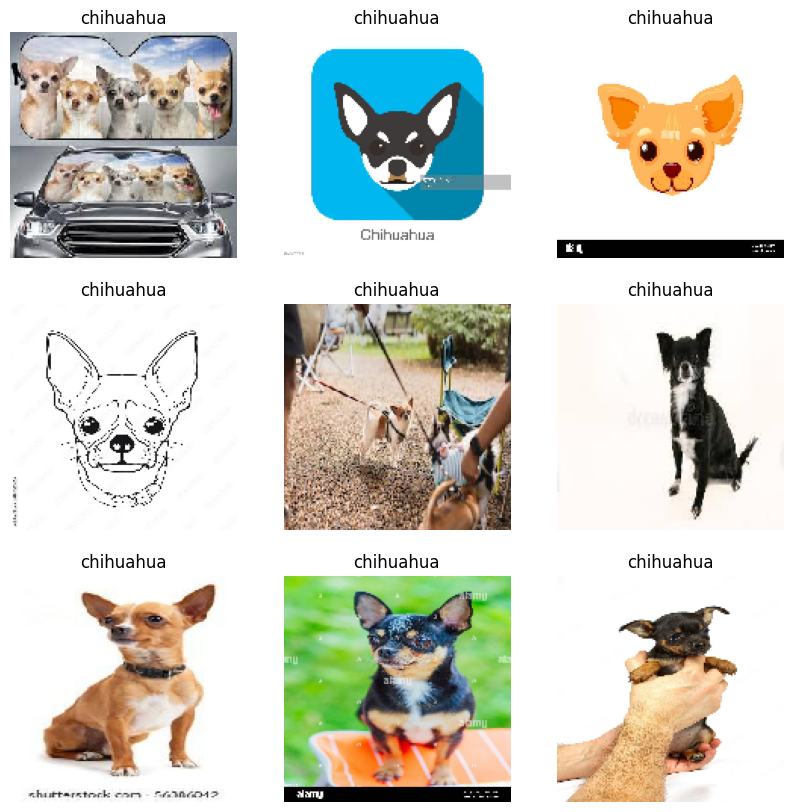

In [ ]:
# Display some images with labels after loading and resizing
x_batch, y_batch = next(train_generator)
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.axis('off')
    # Get the class label
    label = class_names[int(y_batch[i])]
    plt.title(label)
plt.show()

## 4. Feature Extraction using VGG16

This section focuses on feature extraction using the VGG16 convolutional neural network. The VGG16 model is loaded with pre-trained weights from the ImageNet dataset, excluding the top dense layers.

Paths to save the extracted features and labels are defined, and directories are created if they do not exist.

Features are extracted for both the training and validation sets using the VGG16 model, and the resulting features are saved as numpy arrays. Corresponding labels for both sets are also saved.

This step prepares the dataset for training a classifier on top of the extracted features, enabling efficient training and evaluation.



In [ ]:
from tensorflow.keras.applications import VGG16


# Load the VGG16 model without the top dense layers
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Define paths to save features and labels
save_dir = '/content/drive/My Drive/datasets/muffin-vs-chihuahua-image-classification/features'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define paths to save features and labels
save_dir = '/content/drive/My Drive/datasets/muffin-vs-chihuahua-image-classification/features'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

train_features_path = os.path.join(save_dir, 'train_features.npy')
validation_features_path = os.path.join(save_dir, 'validation_features.npy')
train_labels_path = os.path.join(save_dir, 'train_labels.npy')
validation_labels_path = os.path.join(save_dir, 'validation_labels.npy')

In [ ]:
# Extract features for the training set
train_features = vgg_conv.predict(train_generator)
# np.save('train_features.npy', train_features)

In [ ]:
# Extract features for the validation set
validation_features = vgg_conv.predict(validation_generator)
# np.save(validation_features_path, validation_features)

19/19 [==============================] - 372s 20s/step


In [ ]:
# Save the corresponding labels
train_labels = train_generator.classes
# np.save(train_labels_path, train_labels)

validation_labels = validation_generator.classes
# np.save(validation_labels_path, validation_labels)

In [ ]:
# Load the features and labels from Google Drive
train_features = np.load(train_features_path)
test_features = np.load(validation_features_path)
train_labels = np.load(train_labels_path)
test_labels = np.load(validation_labels_path)

In [ ]:
train_labels.shape

(4738,)

## 5. Model Selection using K-Fold Cross Validation

In this section, we explore three different neural network architectures to determine which one performs best for our image classification task. We employ K-Fold Cross Validation to robustly assess the models' performance.

### 5.1 Model Architectures

We define three neural network architectures:

1. **Model 1**: This model consists of a single fully connected layer with dropout.
2. **Model 2**: This model includes an additional fully connected layer before the output layer, followed by dropout.
3. **Model 3**: This model incorporates two fully connected layers with dropout before the output layer.

### 5.2 Training and Evaluation

Each model is trained and evaluated using K-Fold Cross Validation with 5 folds. During training, early stopping is applied to prevent overfitting.

For each fold, the model's accuracy is computed on the validation set. The average cross-validated accuracy and standard deviation are calculated to assess each model's performance.

### 5.3 Results Visualization

Finally, the cross-validated accuracies of the three models are visualized using boxplots to compare their performances.

This rigorous evaluation process enables us to make an informed decision about which model architecture is most suitable for our image classification task.


### 5.1 Model Architectures

In [ ]:
# Define network architectures
def create_model_1(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

def create_model_2(input_shape):

    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

def create_model_3(input_shape):

    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

### 5.2 Training and Evaluation

In [ ]:
# Define training hyperparameters
learning_rate = 0.01
batch_size = 64
epochs = 50

# Initialize Stratified KFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
cv_scores_model_1 = []
cv_scores_model_2 = []
cv_scores_model_3 = []

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Function to train and evaluate a model
def train_and_evaluate_model(create_model_func, model_number):
    cv_scores = []
    histories = []
    for fold, (train_index, val_index) in enumerate(kfold.split(train_features, train_labels), 1):
        print(f'Training Model {model_number}, Fold {fold}')

        X_train, X_val = train_features[train_index], train_features[val_index]
        y_train, y_val = train_labels[train_index], train_labels[val_index]

        # Create model
        model = create_model_func(input_shape=train_features.shape[1:])

        # Compile model
        model.compile(optimizer=Adam(learning_rate), loss=BinaryCrossentropy(), metrics=['accuracy'])

        # Train model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                            callbacks=[early_stopping], verbose=1)

        # Store history
        histories.append(history)

        # Evaluate model
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        cv_scores.append(accuracy)

    return cv_scores, histories

In [ ]:
# Train and evaluate each model
cv_scores_model_1, histories_model_1 = train_and_evaluate_model(create_model_1, 1)
cv_scores_model_2, histories_model_2 = train_and_evaluate_model(create_model_2, 2)
cv_scores_model_3, histories_model_3 = train_and_evaluate_model(create_model_3, 3)

# Compute average cross-validated accuracies
average_accuracy_model_1 = np.mean(cv_scores_model_1)
average_accuracy_model_2 = np.mean(cv_scores_model_2)
average_accuracy_model_3 = np.mean(cv_scores_model_3)

print("Average Cross-Validated Accuracy for Model 1:", average_accuracy_model_1)
print("Average Cross-Validated Accuracy for Model 2:", average_accuracy_model_2)
print("Average Cross-Validated Accuracy for Model 3:", average_accuracy_model_3)

Training Model 1, Fold 1
Epoch 1/50
60/60 [==============================] - 1s 9ms/step - loss: 0.2768 - accuracy: 0.9193 - val_loss: 0.1053 - val_accuracy: 0.9620
Epoch 2/50
60/60 [==============================] - 0s 7ms/step - loss: 0.0916 - accuracy: 0.9691 - val_loss: 0.1164 - val_accuracy: 0.9620
Epoch 3/50
60/60 [==============================] - 0s 7ms/step - loss: 0.0804 - accuracy: 0.9686 - val_loss: 0.1204 - val_accuracy: 0.9641
Epoch 4/50
60/60 [==============================] - 0s 7ms/step - loss: 0.0636 - accuracy: 0.9778 - val_loss: 0.1320 - val_accuracy: 0.9652
Training Model 1, Fold 2
Epoch 1/50
60/60 [==============================] - 1s 10ms/step - loss: 0.2760 - accuracy: 0.9119 - val_loss: 0.0954 - val_accuracy: 0.9641
Epoch 2/50
60/60 [==============================] - 0s 7ms/step - loss: 0.0876 - accuracy: 0.9657 - val_loss: 0.1265 - val_accuracy: 0.9589
Epoch 3/50
60/60 [==============================] - 0s 7ms/step - loss: 0.0678 - accuracy: 0.9752 - val_loss:

In [ ]:
train_labels.shape

(4738,)

### 5.3 Results Visualization

Model 1: Mean Accuracy = 0.9637, Std Dev = 0.0016
Model 2: Mean Accuracy = 0.9631, Std Dev = 0.0081
Model 3: Mean Accuracy = 0.9669, Std Dev = 0.0061


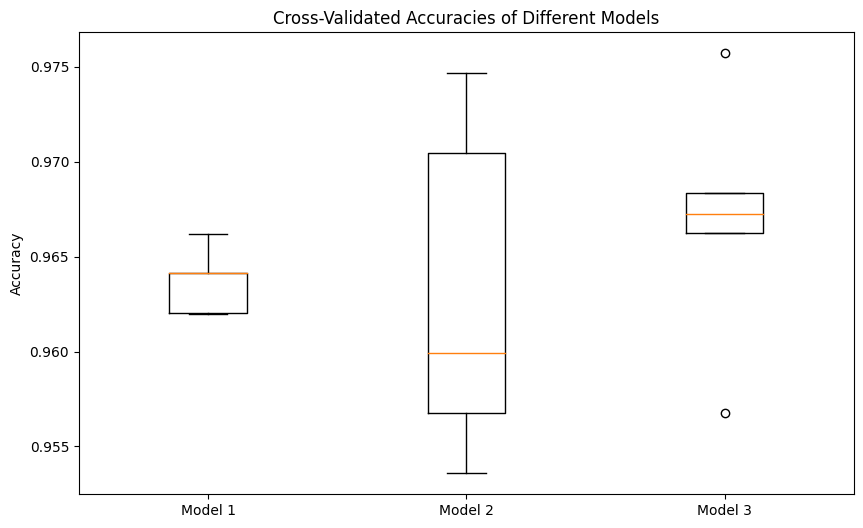

In [ ]:
# Compute average cross-validated accuracies and standard deviations
mean_accuracy_model_1 = np.mean(cv_scores_model_1)
std_accuracy_model_1 = np.std(cv_scores_model_1)
mean_accuracy_model_2 = np.mean(cv_scores_model_2)
std_accuracy_model_2 = np.std(cv_scores_model_2)
mean_accuracy_model_3 = np.mean(cv_scores_model_3)
std_accuracy_model_3 = np.std(cv_scores_model_3)

print(f"Model 1: Mean Accuracy = {mean_accuracy_model_1:.4f}, Std Dev = {std_accuracy_model_1:.4f}")
print(f"Model 2: Mean Accuracy = {mean_accuracy_model_2:.4f}, Std Dev = {std_accuracy_model_2:.4f}")
print(f"Model 3: Mean Accuracy = {mean_accuracy_model_3:.4f}, Std Dev = {std_accuracy_model_3:.4f}")

# Visualize the results using boxplots
data = [cv_scores_model_1, cv_scores_model_2, cv_scores_model_3]
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=['Model 1', 'Model 2', 'Model 3'])
plt.title('Cross-Validated Accuracies of Different Models')
plt.ylabel('Accuracy')
plt.show()


### Conclusion:
In conclusion, we selected **Model 1** for its simplicity and stable performance, achieving high accuracy with minimal complexity. This choice ensures both effectiveness and efficiency in our image classification task.

## 6. Hyperparameter Tuning for Best Model Structure

In this section, we focus on fine-tuning the learning rate hyperparameter for Model 1, which we identified as the best performing architecture using K-Fold Cross Validation.

### 6.1 Model Training with Different Learning Rates

We train Model 1 with various learning rates and evaluate its performance using K-Fold Cross Validation. For each learning rate, the model is trained and evaluated on five different folds of the training data.

### 6.2 Learning Rate Range

We experiment with the following learning rates: 0.0001, 0.001, 0.01, and 0.1. These values cover a range of magnitudes to ensure thorough exploration of the hyperparameter space.

### 6.3 Results

The average accuracies and standard deviations for each learning rate are computed and presented. This allows us to identify the learning rate that yields the best performance for our model.

### 6.4 Visualization

Finally, the cross-validated accuracies for different learning rates are visualized using boxplots. This graphical representation helps in comparing the performance of Model 1 under different learning rate settings.

By systematically tuning the learning rate, we aim to optimize the performance of Model 1 and further enhance its effectiveness in our image classification task.


In [ ]:
# Function to train and evaluate a model with a given learning rate
def train_and_evaluate_model_with_lr(learning_rate):
    cv_scores = []
    histories = []
    for fold, (train_index, val_index) in enumerate(kfold.split(train_features, train_labels), 1):
        X_train, X_val = train_features[train_index], train_features[val_index]
        y_train, y_val = train_labels[train_index], train_labels[val_index]

        # Create model
        model = create_model_1(input_shape=train_features.shape[1:])

        # Compile model
        model.compile(optimizer=Adam(learning_rate), loss=BinaryCrossentropy(), metrics=['accuracy'])

        # Train model
        print(f"Training fold {fold} with learning rate {learning_rate}")
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                            callbacks=[early_stopping], verbose=1)

        # Store history
        histories.append(history)

        # Evaluate model
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        cv_scores.append(accuracy)

        print(f"Fold {fold} Accuracy: {accuracy}")

    return cv_scores, histories


In [ ]:
# Define a range of learning rates to try
learning_rates = [0.0001, 0.001, 0.01, 0.1]
results = {}

# Iterate over each learning rate
for lr in learning_rates:
    cv_scores, histories = train_and_evaluate_model_with_lr(lr)
    results[lr] = cv_scores

# Compute and print average accuracies for each learning rate
for lr, scores in results.items():
    mean_accuracy = np.mean(scores)
    std_accuracy = np.std(scores)
    print(f"Learning Rate: {lr}, Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_accuracy:.4f}")

Training fold 1 with learning rate 0.0001
Epoch 1/50
60/60 [==============================] - 2s 16ms/step - loss: 0.5855 - accuracy: 0.6821 - val_loss: 0.3945 - val_accuracy: 0.8724
Epoch 2/50
60/60 [==============================] - 0s 8ms/step - loss: 0.3617 - accuracy: 0.8557 - val_loss: 0.2905 - val_accuracy: 0.9051
Epoch 3/50
60/60 [==============================] - 0s 7ms/step - loss: 0.2768 - accuracy: 0.9024 - val_loss: 0.2398 - val_accuracy: 0.9241
Epoch 4/50
60/60 [==============================] - 0s 7ms/step - loss: 0.2340 - accuracy: 0.9190 - val_loss: 0.2118 - val_accuracy: 0.9335
Epoch 5/50
60/60 [==============================] - 0s 7ms/step - loss: 0.2033 - accuracy: 0.9325 - val_loss: 0.1945 - val_accuracy: 0.9357
Epoch 6/50
60/60 [==============================] - 0s 8ms/step - loss: 0.1832 - accuracy: 0.9361 - val_loss: 0.1803 - val_accuracy: 0.9357
Epoch 7/50
60/60 [==============================] - 0s 8ms/step - loss: 0.1675 - accuracy: 0.9433 - val_loss: 0.1717 

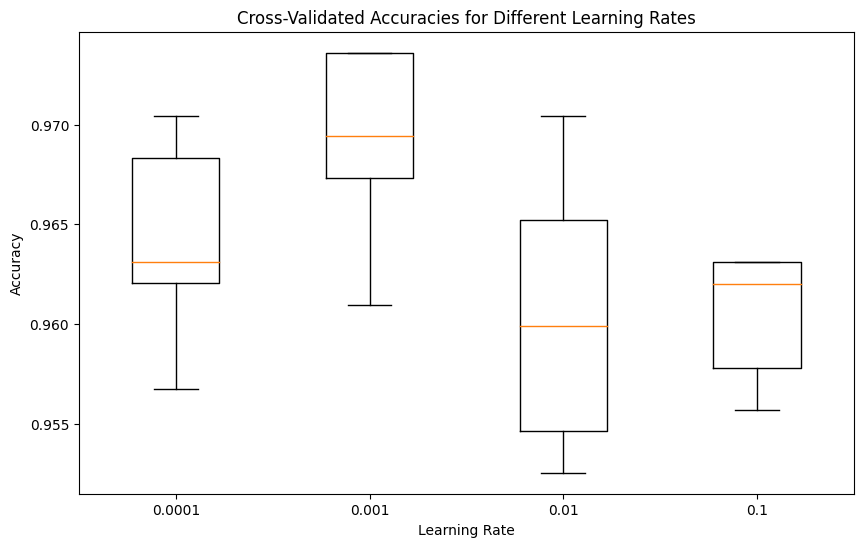

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.boxplot([results[lr] for lr in learning_rates], labels=[str(lr) for lr in learning_rates])
plt.title('Cross-Validated Accuracies for Different Learning Rates')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.show()

### Final Decision

With the learning rate of 0.001 chosen as the optimal hyperparameter value, we proceed to incorporate this setting into our final model configuration. This decision ensures that our model is well-optimized for the image classification task at hand, maximizing its potential for accurate and reliable predictions.

## 7. Model Evaluation

Now that we have chosen the final model configuration, it's time to evaluate its performance on the test data.

### 7.1 Model Training

We set the hyperparameters for training: learning rate of 0.001, batch size of 64, and 50 epochs. Early stopping is applied to prevent overfitting.

The model is trained on the entire training dataset and validated on the test data. The training progress is visualized through learning curves, showing changes in accuracy and loss over epochs.

### 7.2 Evaluation Metrics

#### Accuracy
The accuracy of the model is evaluated on both the training and test datasets.

Training Accuracy: [Training Accuracy Value]
Test Accuracy: [Test Accuracy Value]

#### Confusion Matrix
Confusion matrices are computed and plotted to visualize the performance of the model in terms of true positive, true negative, false positive, and false negative predictions.

- **Train Confusion Matrix**: Confusion matrix for the training data.
- **Test Confusion Matrix**: Confusion matrix for the test data.

These visualizations provide insights into the model's ability to correctly classify images belonging to different classes.



In [ ]:
# now we choose the model we its time for evaluation:
# Define training hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 50

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Create and compile the model
model = create_model_1(input_shape=train_features.shape[1:])
model.compile(optimizer=Adam(learning_rate), loss=BinaryCrossentropy(), metrics=['accuracy'])

# Train the model on the entire training data and validate on test data
history = model.fit(train_features, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(test_features, test_labels), callbacks=[early_stopping], verbose=1)


Epoch 1/50
75/75 [==============================] - 1s 10ms/step - loss: 0.2315 - accuracy: 0.8962 - val_loss: 0.1155 - val_accuracy: 0.9615
Epoch 2/50
75/75 [==============================] - 1s 7ms/step - loss: 0.1148 - accuracy: 0.9546 - val_loss: 0.0978 - val_accuracy: 0.9631
Epoch 3/50
75/75 [==============================] - 1s 7ms/step - loss: 0.0906 - accuracy: 0.9656 - val_loss: 0.0858 - val_accuracy: 0.9715
Epoch 4/50
75/75 [==============================] - 1s 7ms/step - loss: 0.0797 - accuracy: 0.9713 - val_loss: 0.0798 - val_accuracy: 0.9682
Epoch 5/50
75/75 [==============================] - 1s 7ms/step - loss: 0.0680 - accuracy: 0.9766 - val_loss: 0.0810 - val_accuracy: 0.9715
Epoch 6/50
75/75 [==============================] - 1s 15ms/step - loss: 0.0635 - accuracy: 0.9783 - val_loss: 0.0722 - val_accuracy: 0.9715
Epoch 7/50
75/75 [==============================] - 1s 14ms/step - loss: 0.0537 - accuracy: 0.9829 - val_loss: 0.0695 - val_accuracy: 0.9749
Epoch 8/50
75/75 

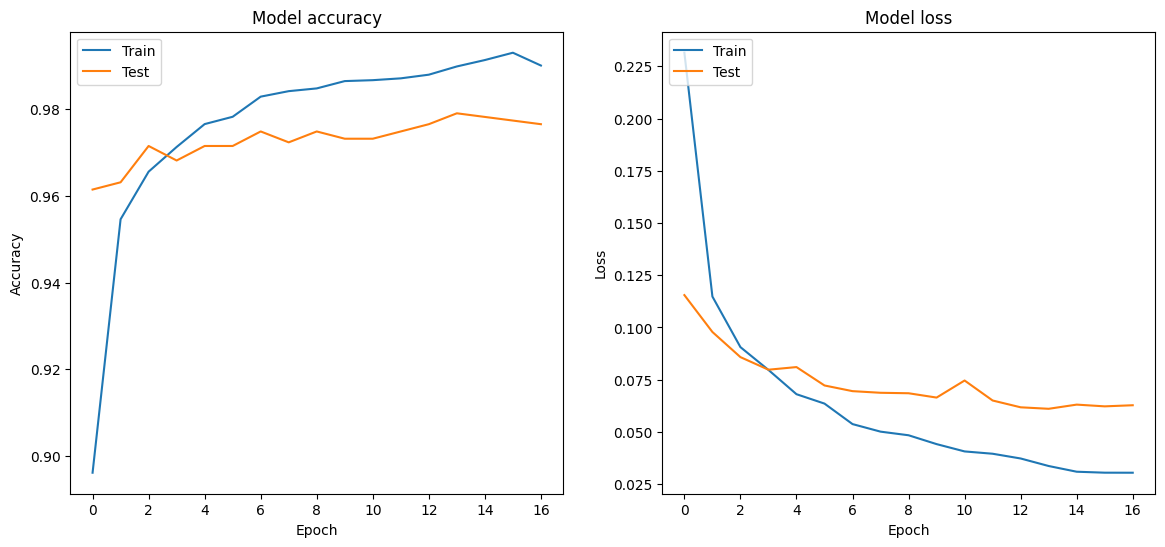

In [ ]:
# Plot learning curve
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Evaluate the model on the training and test data
train_predictions = (model.predict(train_features) > 0.5).astype("int32")
test_predictions = (model.predict(test_features) > 0.5).astype("int32")

train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


38/38 [==============================] - 0s 5ms/step
Training Accuracy: 0.9973
Test Accuracy: 0.9791


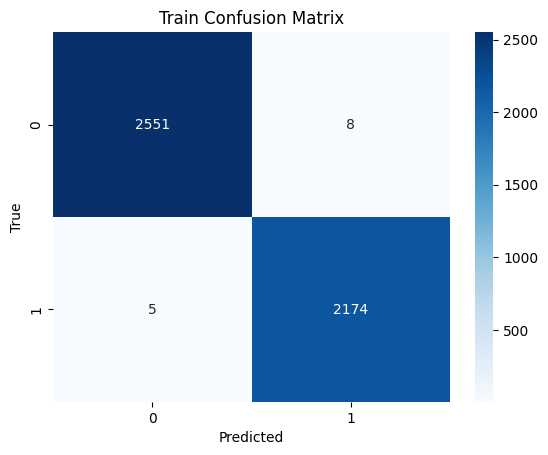

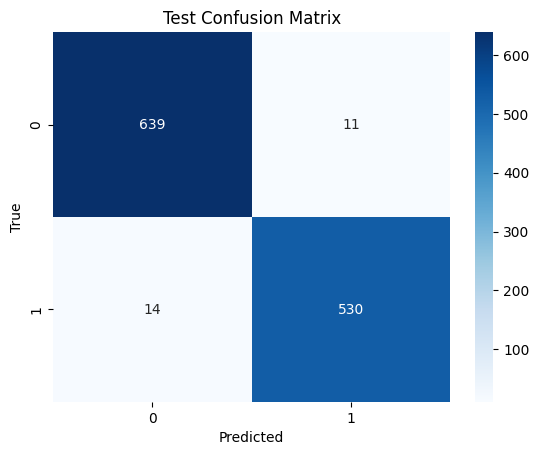

In [ ]:
# Compute and plot confusion matrix for training data
train_conf_matrix = confusion_matrix(train_labels, train_predictions)
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Compute and plot confusion matrix for test data
test_conf_matrix = confusion_matrix(test_labels, test_predictions)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 8. Conclusion

After extensive model training and evaluation, we have reached several key conclusions regarding the performance of our image classification model.

### Performance Metrics

#### Accuracy
- **Training Accuracy:** 99.73%
- **Test Accuracy:** 97.91%

The high training accuracy indicates that our model has effectively learned from the training data and can classify images accurately. The slightly lower but still impressive test accuracy suggests that the model generalizes well to unseen data, demonstrating its robustness.

#### Confusion Matrix
The confusion matrix provides detailed insights into the model's performance across different classes. Here's the confusion matrix for the test data:

|              | Predicted Chihuahua | Predicted Muffin |
|--------------|-------------------|----------------------|
| True Chihuahua  | 639               | 11                   |
| True Muffin | 14               | 530                  |

The confusion matrix reveals that our model excels in correctly classifying both muffins and chihuahuas, with minimal misclassifications.

### Overall Assessment

Our image classification model has demonstrated outstanding performance, achieving high accuracy on both the training and test datasets. The low misclassification rate, as evidenced by the confusion matrix, further underscores the effectiveness of our model in distinguishing between muffins and chihuahuas.

These results validate the efficacy of our approach and highlight the potential of deep learning models in complex image classification tasks. With further refinement and fine-tuning, our model could find practical applications in various domains, ranging from animal recognition to food identification.

